In [1]:
import os
import sys
from datetime import date
from tme_utils import (
    EventTypes,
    get_client,
    query_blocks,
    query_events,
    query_receipt,
    query_state
)

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]

In [2]:
project = "celo-testnet"
dataset = "tme_test_stakeoff"
partition = "*"
table = "tme_stakeoff_test_{0}".format(partition)
# dataset = "transaction_metrics_exporter"
# partition = date.today().strftime("%Y%m%d")
# table = "transaction_metrics_exporter_{0}".format(partition)

window_min = 100500
window_max = 201000

client = get_client(project)

tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [3]:
df_blocks = query_blocks(client, table_path, window_min, window_max)
df_receipt = query_receipt(client, table_path, window_min, window_max)
df_state = query_state(client, table_path, window_min, window_max, df_blocks)
df_events = query_events(client, table_path, window_min, window_max, df_state)
df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,9.813200e+04,98132.000000,9.813200e+04,98132.0,98132.000000,98131.000000
mean,1.579458e+09,150957.232890,9.454962e+04,20000000.0,1.050188,5.166889
std,1.454102e+05,28822.293064,1.663535e+05,0.0,0.320878,2.233487
min,1.579203e+09,100500.000000,0.000000e+00,20000000.0,1.000000,5.000000
25%,1.579334e+09,126501.750000,0.000000e+00,20000000.0,1.000000,5.000000
50%,1.579459e+09,151167.500000,4.106900e+04,20000000.0,1.000000,5.000000
75%,1.579583e+09,175750.250000,1.321380e+05,20000000.0,1.000000,5.000000
max,1.579710e+09,201000.000000,1.975836e+07,20000000.0,5.000000,110.000000


In [4]:
query_balance = f"""
SELECT 
    jsonPayload.blockNumber,
    jsonPayload.values.balance,
    jsonPayload.contract,
    jsonPayload.function,
    jsonPayload.args
FROM `celo-testnet.tme_test_stakeoff.transaction_metrics_exporter_20200401` 
WHERE 
    jsonPayload.function="balanceOf" and
    jsonPayload.event='{EventTypes.RECEIVED_STATE.value}' and
    jsonPayload.blockNumber >= {window_min} and
    jsonPayload.blockNumber <= {window_max}
ORDER BY 
    jsonPayload.blockNumber DESC
"""

df_balance = client.query(
    query_balance,
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()


In [5]:
df_balance.head()

,blockNumber,balance,contract,function,args
0,140000.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"
1,140000.0,9.983510e+25,GoldToken,balanceOf,None
2,139999.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"
3,139999.0,9.983510e+25,GoldToken,balanceOf,None
4,139998.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.579710e+09,201000.0,29683.0,20000000.0,4,5.0
1,1.579710e+09,200999.0,123218.0,20000000.0,1,5.0
2,1.579710e+09,200998.0,173073.0,20000000.0,1,5.0
3,1.579710e+09,200997.0,34407.0,20000000.0,1,5.0
4,1.579710e+09,200996.0,60642.0,20000000.0,1,5.0


last block  : 201000 on 1579710355.0
first block : 100500 on 1579203323.0
blocks load : 98132
transactions: 103057
mean gasUsed: 94550 GcWei
mean blocktime: 5.2 s


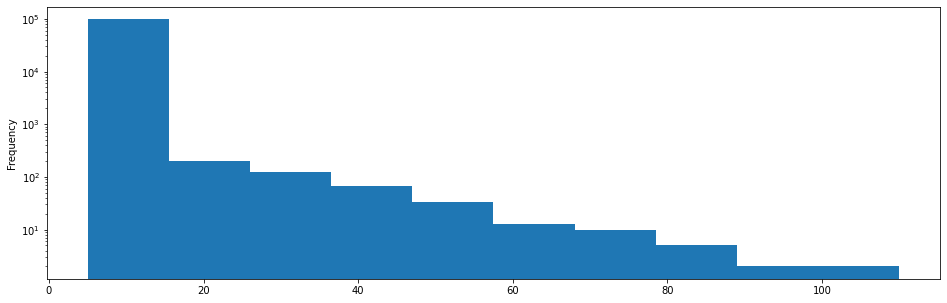

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.1f} s")

In [8]:
df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,98043.000000,9.781100e+04,9.783400e+04,97824.000000,9.783300e+04,9.783300e+04,9.781900e+04,9.804300e+04,9.804300e+04,98043.0,98043.000000,98042.000000
mean,150957.917291,6.003213e+26,1.614716e+24,0.997794,9.965832e+23,9.977916e+23,1.089212e+26,1.579458e+09,9.450347e+04,20000000.0,1.050233,5.145264
std,28814.719570,6.142572e+22,1.809799e+20,0.001007,2.249978e+21,1.668181e+21,2.151785e+23,1.453720e+05,1.663500e+05,0.0,0.321020,2.001823
min,100500.000000,6.002137e+26,1.614167e+24,0.996000,9.937832e+23,9.741356e+23,1.082324e+26,1.579203e+09,0.000000e+00,20000000.0,1.000000,5.000000
25%,126531.500000,6.002694e+26,1.614596e+24,0.997000,9.947590e+23,9.977073e+23,1.089266e+26,1.579335e+09,0.000000e+00,20000000.0,1.000000,5.000000
50%,151174.000000,6.003218e+26,1.614716e+24,0.998000,9.968169e+23,9.980552e+23,1.089266e+26,1.579459e+09,4.106900e+04,20000000.0,1.000000,5.000000
75%,175736.500000,6.003741e+26,1.614830e+24,0.999000,9.974185e+23,9.984169e+23,1.089266e+26,1.579583e+09,1.321380e+05,20000000.0,1.000000,5.000000
max,201000.000000,6.004281e+26,1.615279e+24,1.000000,1.023144e+24,9.996349e+23,1.095966e+26,1.579710e+09,1.975836e+07,20000000.0,5.000000,110.000000


In [9]:
df_state.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
98038,200996.0,2020-03-26 16:36:40.957919+00:00,6.004281e+26,1.614168e+24,0.997,9.953621e+23,9.980781e+23,1.095966e+26,1.579710e+09,60642.0,20000000.0,1,5.0,2020-01-22 16:25:35
98039,200997.0,2020-03-26 16:36:41.403662+00:00,6.004281e+26,1.614168e+24,0.997,9.953621e+23,9.980781e+23,1.095966e+26,1.579710e+09,34407.0,20000000.0,1,5.0,2020-01-22 16:25:40
98040,200998.0,2020-03-26 16:36:41.850929+00:00,6.004281e+26,1.614168e+24,0.997,9.956929e+23,9.977481e+23,1.095966e+26,1.579710e+09,173073.0,20000000.0,1,5.0,2020-01-22 16:25:45
98041,200999.0,2020-03-26 16:36:42.440821+00:00,6.004281e+26,1.614168e+24,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,123218.0,20000000.0,1,5.0,2020-01-22 16:25:50
98042,201000.0,2020-03-26 16:36:42.883135+00:00,6.004281e+26,1.614168e+24,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,29683.0,20000000.0,4,5.0,2020-01-22 16:25:55


Text(0, 0.5, 'SortedOracles.medianRate')

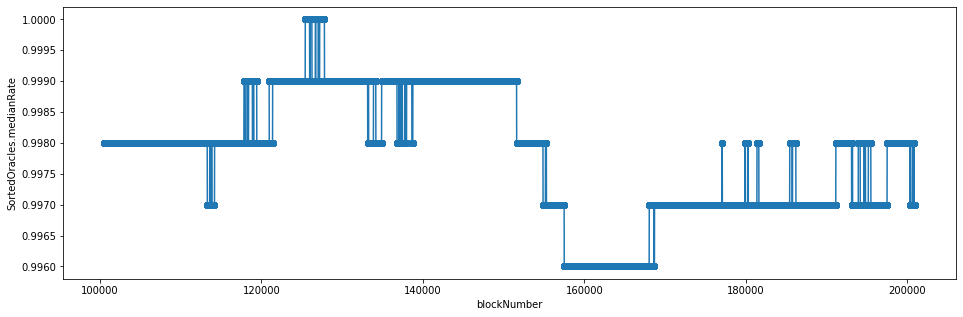

In [10]:
df_slice = df_state[1:]
df_sortedOracles = df_slice.set_index('blockNumber')['medianRate']
ax = df_sortedOracles.plot(marker='o')
ax.set_ylabel("SortedOracles.medianRate")

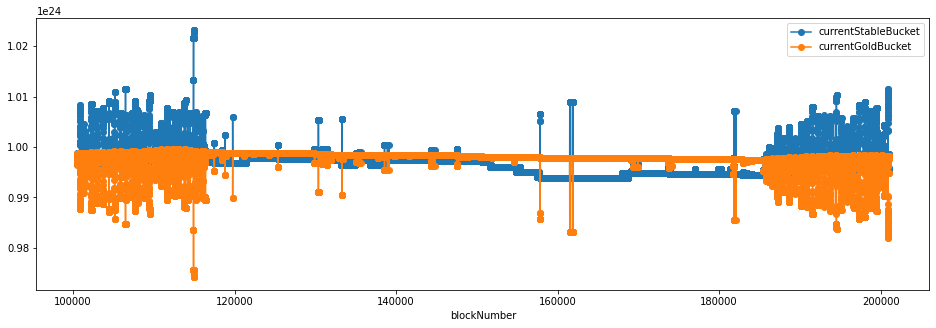

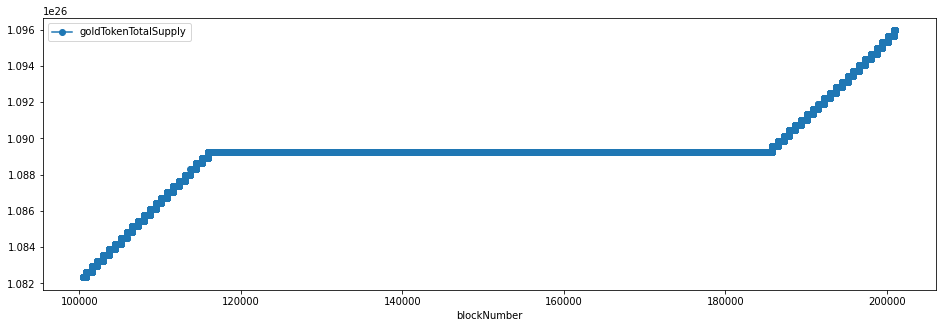

In [11]:
df_stableToken = df_state.set_index('blockNumber')[['currentStableBucket']]
ax = df_stableToken.plot(marker='o')
# df_stableToken[df_stableToken<2e24].plot(marker='o')
df_goldbucket = df_state.set_index('blockNumber')[['currentGoldBucket']]
df_goldbucket.plot(marker='o', ax=ax)
df_goldToken = df_state.set_index('blockNumber')[['goldTokenTotalSupply']]
df_goldToken.plot(marker='o')

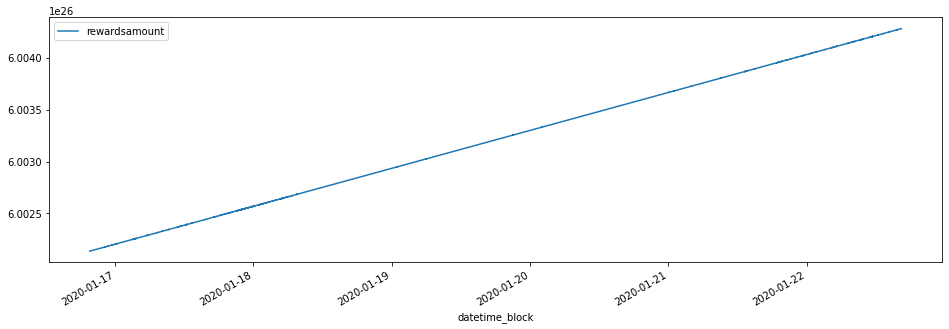

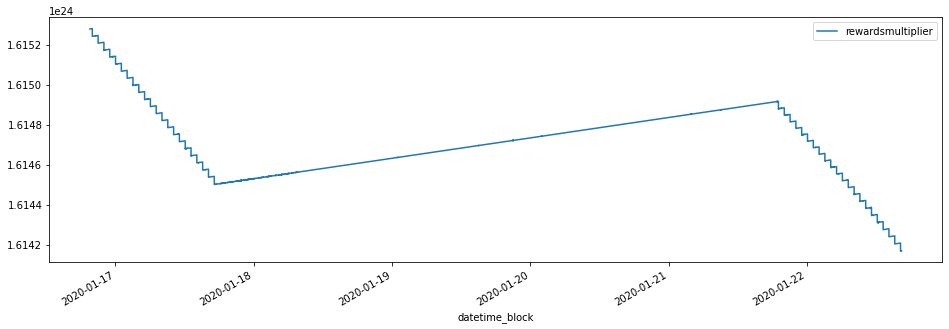

In [12]:
df_rewardsAmount = df_state.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df_state.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
df_events.describe()

,blockNumber,sellamount,buyamount,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,142464.000000,6.817000e+03,6.817000e+03,1.420330e+05,1.420610e+05,142132.000000,1.420460e+05,1.420460e+05,1.419610e+05,1.424640e+05,1.424640e+05,142464.0,142464.000000,142449.000000
mean,139409.347204,1.871370e+20,1.852504e+20,6.002966e+26,1.614752e+24,0.997924,9.974909e+23,9.974529e+23,1.088369e+26,1.579400e+09,2.993142e+05,20000000.0,1.149806,5.344755
std,33334.548218,6.515090e+20,6.426831e+20,7.107391e+22,2.350597e+20,0.000883,2.755087e+21,2.343396e+21,2.775014e+23,1.681778e+05,3.167618e+05,0.0,0.574701,2.847702
min,100500.000000,0.000000e+00,0.000000e+00,6.002137e+26,1.614167e+24,0.996000,9.937832e+23,9.741356e+23,1.082324e+26,1.579203e+09,2.645300e+04,20000000.0,1.000000,5.000000
25%,110796.000000,0.000000e+00,0.000000e+00,6.002356e+26,1.614561e+24,0.997000,9.961359e+23,9.974421e+23,1.086724e+26,1.579255e+09,1.203680e+05,20000000.0,1.000000,5.000000
50%,126223.000000,5.214000e+03,5.198000e+03,6.002686e+26,1.614749e+24,0.998000,9.973301e+23,9.982177e+23,1.089266e+26,1.579333e+09,1.903260e+05,20000000.0,1.000000,5.000000
75%,171478.500000,2.493466e+20,2.484647e+20,6.003647e+26,1.614900e+24,0.998000,9.978571e+23,9.987498e+23,1.089266e+26,1.579561e+09,3.521790e+05,20000000.0,1.000000,5.000000
max,201000.000000,1.500000e+22,1.476325e+22,6.004281e+26,1.615279e+24,1.000000,1.023144e+24,9.996349e+23,1.095966e+26,1.579710e+09,1.975836e+07,20000000.0,5.000000,110.000000


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
0,201000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,330000000000000000000,...,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,29683.0,20000000.0,4,5.0,2020-01-22 16:25:55
1,201000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,330000000000000000000,...,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,29683.0,20000000.0,4,5.0,2020-01-22 16:25:55
2,201000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,330000000000000000000,...,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,29683.0,20000000.0,4,5.0,2020-01-22 16:25:55
3,201000.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,330000000000000000000,...,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,29683.0,20000000.0,4,5.0,2020-01-22 16:25:55
4,200999.0,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,Transfer,None,None,None,None,None,None,147239986338494718456,...,0.997,9.958406e+23,9.976009e+23,1.095966e+26,1.579710e+09,123218.0,20000000.0,1,5.0,2020-01-22 16:25:50


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer                          114395
Approval                            9226
Exchanged                           6817
ValidatorGroupVoteCast              2940
GoldLocked                          2914
ValidatorGroupVoteActivated         2199
AttestationsRequested                971
AttestationIssuerSelected            963
AttestationCompleted                 799
ValidatorGroupVoteRevoked            342
AccountMetadataURLSet                152
GoldUnlocked                         123
GoldWithdrawn                        119
ValidatorAffiliated                   79
ValidatorGroupMemberAdded             64
ValidatorDeaffiliated                 54
AccountNameSet                        42
ValidatorGroupMemberRemoved           38
AccountCreated                        38
ValidatorRegistered                   30
AttestationSignerAuthorized           28
AccountDataEncryptionKeySet           28
ValidatorSignerAuthorized             27
ValidatorGroupMarkedIneligible        16
Partic

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0xe820238dc7B75B7602DaFC7ffcCd35C9EF5e2fdF    703
0x49c3C6A9B0c17aC32169FFc45998aA80029128B3    702
0x7f53F21F0fd99983fC1d0d527AC5fF6feD52B9a0    640
0x92fb67ace261e016678Cd221972F21f5c03D781a    633
0xd99bedef76c9Caa7eC0Cfdaa79c1b9330Bb02061    521
                                             ... 
0x6Af7F878Dc47D3cD83507b760aba82Af45C9F902      1
0x694fb0e26FC592984C8A310eb4FE9BcC3037cA48      1
0x66D4902810a03f45015998A8e92Be8E2Fa49c05A      1
0x62cEd47F08C104920fFA023c8d8F75fF18FDfc1d      1
0x9dba468122b12Cd04BF4828c57F67a87Fe03BBf0      1
Name: exchanger, Length: 182, dtype: int64

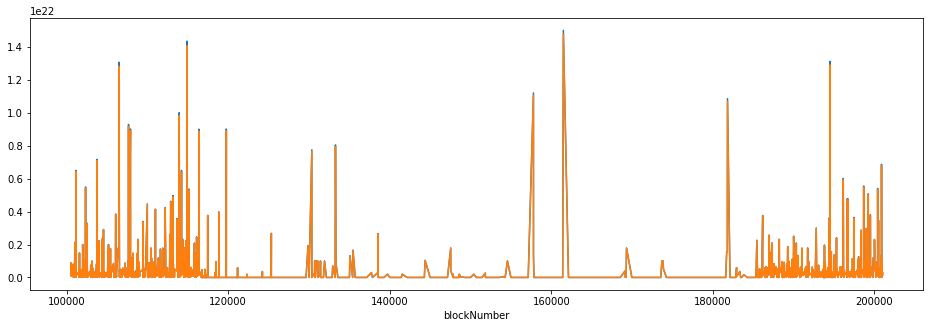

In [17]:
(df_exchange['sellamount']).plot()
(df_exchange['buyamount']).plot()

exchanger     3
buyamount     3
sellamount    3
soldgold      3
dtype: int64


exchanger     6814
buyamount     6814
sellamount    6814
soldgold      6814
dtype: int64

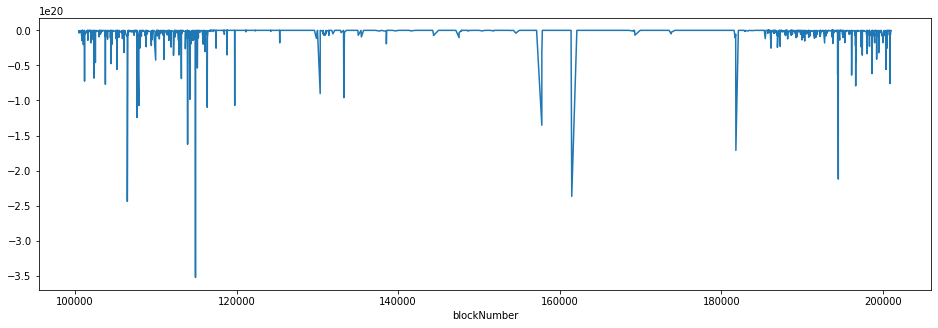

In [18]:
# difference
(df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()


In [19]:
df_ex = df_events.set_index('blockNumber')[['buyamount', 'sellamount', 'currentStableBucket', 'currentGoldBucket', 'soldgold']]
df_ex = df_ex[df_ex.buyamount.notna()]

Text(0, 0.5, 'currentGoldBucket')

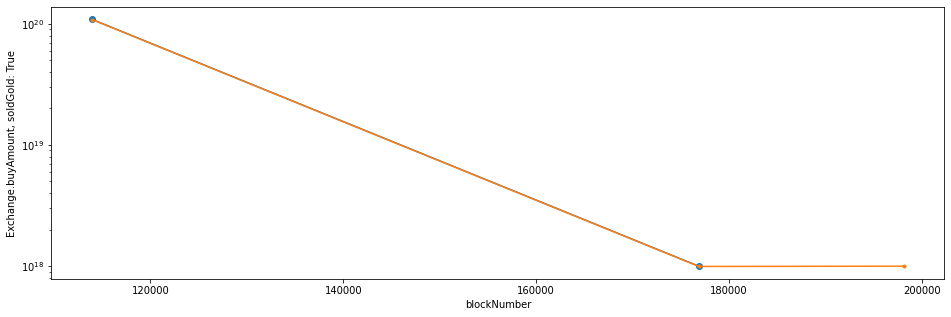

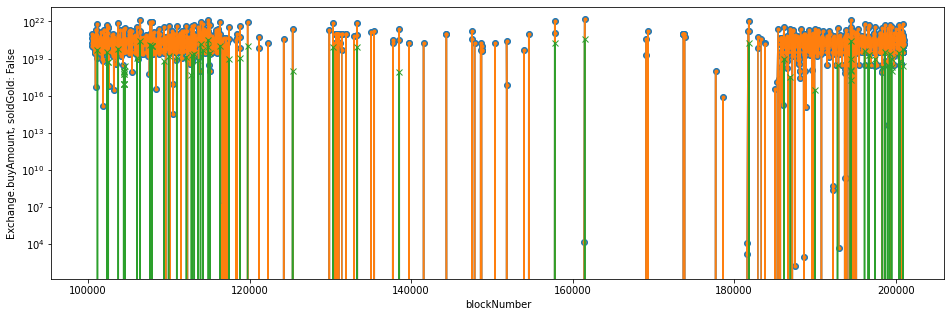

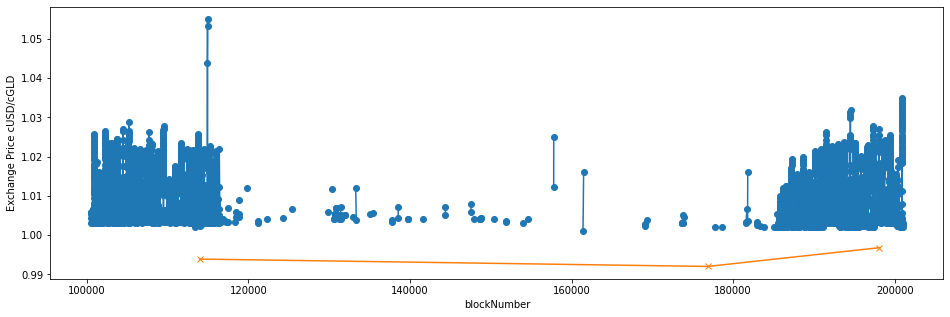

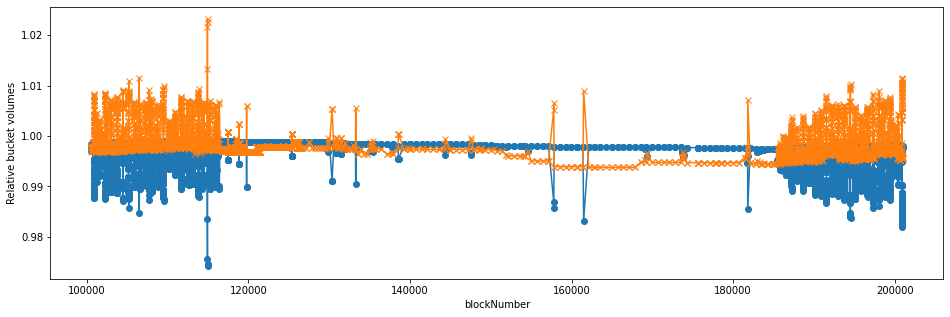

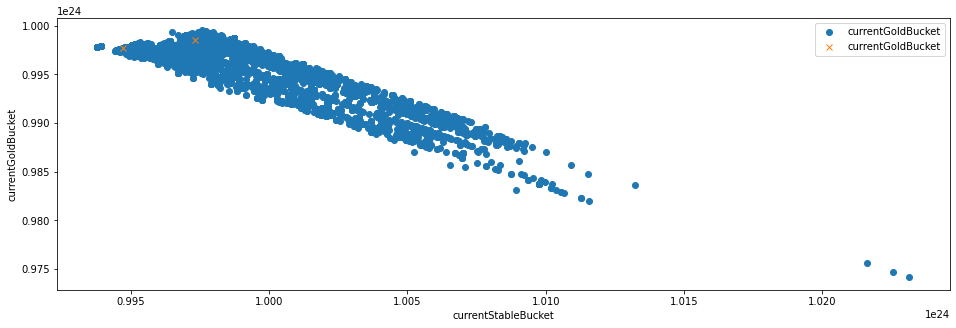

In [20]:
def estimate_buyamount(soldGold):
    df_buy = df_ex[df_ex.soldgold == soldGold]
    Ab = df_buy.buyamount
    As = df_buy.sellamount
    Bs = df_buy.currentStableBucket
    Bg = df_buy.currentGoldBucket
    Bbuy = Bs if soldGold else Bg
    Bsell = Bg if soldGold else Bs

    # buyamount computation is
    # Asell = (1-spread)*As
    # Abuy = Asell/(Bsell+Asell)*Bbuy
    spread = 0
    Asell = (1-spread)*As
    Abuy_hat = Asell/(Bsell+Asell)*Bbuy
    # Abuy_hat = Asell/(Bsell)*Bbuy
    
    return df_buy, Abuy_hat, Bbuy, Bsell


soldGold = True
df_buy_sellgold, Abuy_hat_sellgold, Bbuy_sellgold, Bsell_sellgold = estimate_buyamount(soldGold)
ax = Abuy_hat_sellgold.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellgold.buyamount.plot(marker='.')
(df_buy_sellgold.buyamount - Abuy_hat_sellgold).plot(marker='x', logy=True)

soldGold = False
df_buy_sellusd, Abuy_hat_sellusd, Bbuy_sellusd, Bsell_sellusd = estimate_buyamount(False)
plt.figure()
ax = Abuy_hat_sellusd.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellusd.buyamount.plot(marker='.')
(df_buy_sellusd.buyamount - Abuy_hat_sellusd).plot(marker='x', logy=True)

plt.figure()
ax = (df_buy_sellusd.sellamount/df_buy_sellusd.buyamount).plot(marker='o')
(df_buy_sellgold.buyamount/df_buy_sellgold.sellamount).plot(marker='x')
ax.set_ylabel(f"Exchange Price cUSD/cGLD")

plt.figure()
ax = (df_buy_sellusd.currentGoldBucket/1e24).plot(marker='o')
(df_buy_sellusd.currentStableBucket/1e24).plot(marker='x')
ax.set_ylabel(f"Relative bucket volumes")

fig, ax = plt.subplots(1, 1)
df_buy_sellusd.plot(x='currentStableBucket', y='currentGoldBucket', style='o', ax=ax)
df_buy_sellgold.plot(x='currentStableBucket', y='currentGoldBucket', style='x', ax=ax)
ax.set_ylabel(f"currentGoldBucket")

In [21]:
df_goldlocked = df_events[df_events.eventName == "GoldLocked"].set_index('blockNumber')[['account', 'value']]
df_goldlocked[['value']] = df_goldlocked[['value']].astype('float')
df_goldlocked.groupby('account').value.sum().sort_values(ascending=False)
df_goldlocked[df_goldlocked.account == "0x775a5C899Fd4A7CDD54e9f41738087748CfcB953"].groupby('account').value.sum().sort_values(ascending=False)

Series([], Name: value, dtype: float64)

In [22]:
df_receipt.head()

,blockNumber,from,address,topic
0,201000.0,0xe89897510bfb2fc0647325fb6d580594c061acbf,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
1,201000.0,0xe89897510bfb2fc0647325fb6d580594c061acbf,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0x000000000000000000000000e89897510bfb2fc06473...
2,201000.0,0xe89897510bfb2fc0647325fb6d580594c061acbf,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0x0000000000000000000000006d89bb74e1ea0b473172...
3,201000.0,0xe89897510bfb2fc0647325fb6d580594c061acbf,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
4,201000.0,0xe89897510bfb2fc0647325fb6d580594c061acbf,0x14D449EF428e679da48B3e8CfFa9036fF404B28A,0x000000000000000000000000e89897510bfb2fc06473...


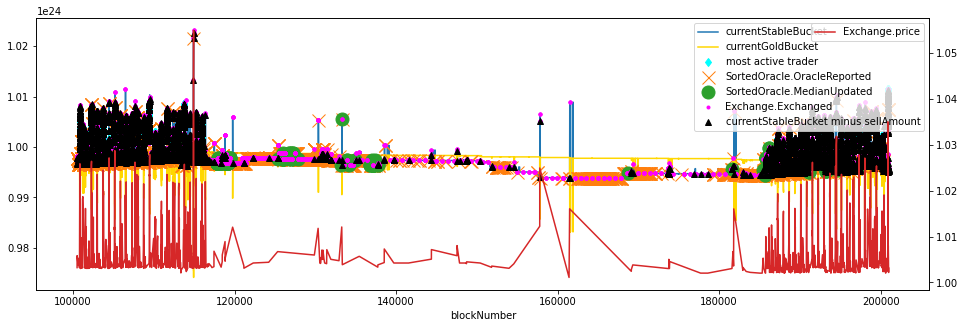

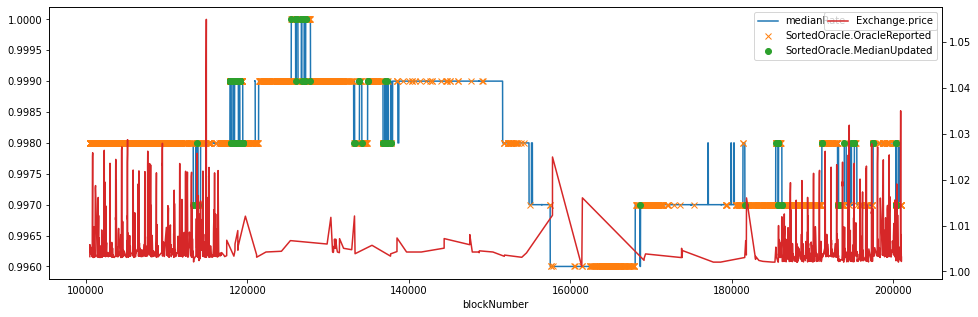

In [23]:
SortedOraclesAddress = '0x91061bF2F509AF76aa01F46E9F3E97577a5a80BA'
OracleReported = '0xdbf09271932e018b9c31e9988e4fbe3109fdd79d78f5d19a764dfb56035ed775'
MedianUpdated = '0x01f3db74cdcb3b158f2144fb78c5ab54e9e8a8c09d3d3b7713050cdb6b6bcb97'
Exchange = '0xC8FD77490A12F46709BffbCC0FCe35740Da8D860'
Exchanged = '0x402ac9185b4616422c2794bf5b118bfcc68ed496d52c0d9841dfa114fdeb05ba'

def filter_event(_df, event, arg='topic'):
    df_event_matches = _df[_df[arg] == event]
    return df_event_matches \
        .merge(df_events, left_on='blockNumber', right_on='blockNumber', suffixes=('_receipt', '')) \
        .merge(df_state, left_on='blockNumber', right_on='blockNumber', suffixes=('', '_state'))

df_report = filter_event(df_receipt, OracleReported)
df_median = filter_event(df_receipt, MedianUpdated)
df_exchanged = filter_event(df_receipt, Exchanged)

df_price = df_buy_sellusd[df_buy_sellusd.index>=window_min]
df_price = df_price[df_price.index<=window_max]
df_price = df_price[df_price.sellamount>0]
price_exchange = df_price.sellamount/df_price.buyamount

df_exchangers = df_exchanged.groupby('from_receipt').count().sort_values(by='blockNumber', ascending=False)
top_exchanger = df_exchangers.index[0] if len(df_exchangers.index) else None

df_active_trader = filter_event(df_receipt, top_exchanger, 'from')
df_active_trader = df_active_trader[df_active_trader.sellamount>0]
fig, ax = plt.subplots()
df_state.set_index('blockNumber').currentStableBucket.plot(ax=ax)
df_state.set_index('blockNumber').currentGoldBucket.plot(ax=ax, marker=".", ms=0, color='gold')
df_active_trader.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="d", linestyle='None', label="most active trader", color="cyan")
df_report.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="x", ms=13, linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="o", ms=13, linestyle='None', label="SortedOracle.MedianUpdated")
df_exchanged.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker=".", linestyle='None', label="Exchange.Exchanged", color="magenta")
df_volumes = df_exchanged.set_index('blockNumber')
df_volumes = df_volumes[df_volumes.sellamount>0]
(df_volumes.currentStableBucket - df_volumes.sellamount).plot(ax=ax, marker="^", linestyle='None', color="black", label="currentStableBucket minus sellAmount")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

fig, ax = plt.subplots()
df_state.set_index('blockNumber').medianRate.plot(ax=ax)
df_report.set_index('blockNumber').medianRate.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').medianRate.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [24]:
df_exchangers.head()

,blockNumber,address_receipt,topic,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,...,medianRate_state,currentStableBucket_state,currentGoldBucket_state,goldTokenTotalSupply_state,timestamp_block_state,gasUsed_state,gasLimit_state,txAmount_state,blocktime_state,datetime_block_state
from_receipt,,,,,,,,,,,,,,,,,,,,,
0xe820238dc7b75b7602dafc7ffccd35c9ef5e2fdf,5351,5351,5351,5351,5351,14,0,0,0,328,...,5332,5332,5332,5301,5351,5351,5351,5351,5351,5351
0x49c3c6a9b0c17ac32169ffc45998aa80029128b3,4552,4552,4552,4552,4552,26,0,0,0,164,...,4543,4539,4539,4532,4552,4552,4552,4552,4552,4552
0x92fb67ace261e016678cd221972f21f5c03d781a,4332,4332,4332,4332,4332,18,0,0,0,156,...,4293,4306,4306,4319,4332,4332,4332,4332,4332,4332
0x7f53f21f0fd99983fc1d0d527ac5ff6fed52b9a0,4283,4283,4283,4283,4283,23,0,0,0,169,...,4267,4261,4261,4237,4283,4283,4283,4283,4283,4283
0xd99bedef76c9caa7ec0cfdaa79c1b9330bb02061,4035,4035,4035,4035,4035,11,0,0,0,126,...,4033,4025,4025,4021,4035,4035,4035,4035,4035,4035


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

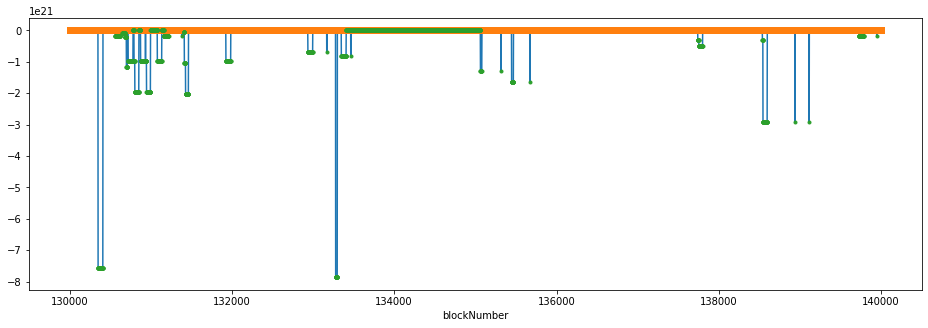

In [25]:
r = df_state.set_index('blockNumber').currentGoldBucket.diff()
exchange_balance = (0.01*(df_balance[df_balance.contract=="GoldToken"].set_index('blockNumber').balance))
bucket_diff = (df_state.set_index('blockNumber').currentGoldBucket - exchange_balance)

fig, ax = plt.subplots()
bucket_diff.plot(ax=ax)
bucket_diff[bucket_diff.abs()<1e10].plot(ax=ax, marker='s', linestyle='None')
bucket_diff[bucket_diff!=0].plot(ax=ax, marker='.', linestyle='None')
bucket_diff[r>0].plot(ax=ax, marker='o', linestyle='None')
bucket_diff[r<0].plot(ax=ax, marker='^', linestyle='None')
bucket_diff[r>0]

In [ ]:
bucket_diff.hist().plot()